In [ ]:
# !git clone https://github.com/shallex/Team12_ML24.git

Cloning into 'Team12_ML24'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 60 (delta 9), reused 47 (delta 6), pack-reused 0
Receiving objects: 100% (60/60), 22.67 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [23]:
import torch
import torchvision
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output

from torchvision.datasets import MNIST
from torch.utils.data import Dataset

# Code

## Utils

In [24]:
def show_images(images: list, labels: list[str]=None, n_cols: int=3):
    """
    Show list of images

    Parameters
    ----------
    images : list

    """

    if labels is None:
        labels = [f"pic. {index}" for index in range(1, len(images) + 1)]
    else:
        assert len(images) == len(labels)

    n_rows = len(images) // n_cols + (1 if len(images) % n_cols else 0)

    fig = plt.figure()
    for index, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.tight_layout()
        plt.imshow(image[0], cmap='gray', interpolation='none')
        plt.title(label)
        plt.xticks([])
        plt.yticks([])

    plt.show()


def evaluate_model(model, dataloader, loss, device, autoencoder_metrics) -> float:
    # Exit training mode.
    was_in_training = model.training
    model.eval()

    with torch.no_grad():
        avg_loss = 0.0
        total_samples = 0
        for batch in dataloader:
            global_idx, x, y = batch
            batch_size = x.shape[0]

            y_pred = model(x.to(device))
            _loss = loss(y_pred, y.to(device))

            avg_loss += _loss.item() * batch_size
            total_samples += batch_size

        avg_loss /= total_samples

    # Return to the original mode.
    model.train(was_in_training)

    return avg_loss, autoencoder_metrics



def train_autoencoder(
    autoencoder,
    train_dataloader,
    test_dataloader,
    autoencoder_loss,
    autoencoder_opt,
    device,
    n_epochs: int=10,
    callback: callable=None, ) -> dict():


    autoencoder_metrics = {
        "train_loss" : [],
        "test_loss" : [],
        "samples_losses": {}
    }

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch №{epoch}")

        sum_loss = 0.0
        total_samples = 0
        for index, batch in tqdm(enumerate(train_dataloader)):
            global_idx, x, target = batch
            batch_size = x.shape[0]

            autoencoder_opt.zero_grad()
            y_pred = autoencoder(x.to(device))
            _loss = autoencoder_loss(y_pred, x.to(device))
            _loss.backward()
            autoencoder_opt.step()

            sum_loss += _loss.item() * len(batch)
            total_samples += len(batch)


        with torch.no_grad():
          for index, batch in tqdm(enumerate(train_dataloader_autoencoder_for_metrics)):
            global_idx, x, target = batch
            y_pred = autoencoder(x.to(device))
            _loss = autoencoder_loss_for_metric(y_pred, x.to(device))
            _loss = torch.mean(_loss, dim=list(range( len(_loss.shape) ))[1:])

            for i, g_idx in enumerate(global_idx):
                  g_idx = g_idx.item()
                  if autoencoder_metrics["samples_losses"].get(g_idx):
                    autoencoder_metrics["samples_losses"][g_idx].append(_loss[i].mean().item())
                  else:
                    autoencoder_metrics["samples_losses"][g_idx] = [_loss[i].mean().item()]


        autoencoder_metrics["train_loss"].append(sum_loss / total_samples)

        #train_loss = evaluate_model(autoencoder, train_dataloader, autoencoder_loss, device)
        #autoencoder_metrics["train_loss"].append(train_loss)
        test_loss, autoencoder_metrics = evaluate_model(autoencoder, test_dataloader, autoencoder_loss, device, autoencoder_metrics)
        autoencoder_metrics["test_loss"].append(test_loss)

        if not (callback is None):
            callback(autoencoder, autoencoder_metrics)

    return autoencoder_metrics

## Model

### Small model

In [25]:
class MNIST_ConvEncoder_small(torch.nn.Module):
    """
    MNIST Convolutional encoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Noise.
        self.dropout = torch.nn.Dropout(0.1)

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding='same')

        self.maxpool2d = torch.nn.MaxPool2d((2,2))

        # Dense.
        self.linear_1 = torch.nn.Linear(784, 64)
        self.linear_2 = torch.nn.Linear(64, self.latent_dim)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution №1
        x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.maxpool2d(x)
        layer_1 = self.activation(x)

        # Convolution №2
        x = self.dropout(layer_1)
        x = self.conv2d_2(x)
        x = self.maxpool2d(x)
        layer_2 = self.activation(x)

        # Dense №1
        x = torch.flatten(layer_2, 1)
        x = self.linear_1(x)
        layer_4 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_4)
        layer_5 = self.sigmoid(x)

        return layer_5



class MNIST_ConvDecoder_small(torch.nn.Module):
    """
    MNIST Convolutional decoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(8, 1, kernel_size=3, padding='same')

        self.upsample = torch.nn.Upsample(scale_factor=2)

        # Dense.
        self.linear_1 = torch.nn.Linear(latent_dim, 128)
        self.linear_2 = torch.nn.Linear(128, 784)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)

        # Convolution №1
        x = torch.reshape(layer_2, (-1, 16, 7, 7))
        x = self.conv2d_2(x)
        x = self.upsample(x)
        layer_4 = self.activation(x)

        # Convolution №3
        x = self.conv2d_3(layer_4)
        x = self.upsample(x)
        layer_5 = x #self.sigmoid(x)

        return layer_5

### Big model

In [8]:
class MNIST_ConvEncoder_big(torch.nn.Module):
    """
    MNIST Convolutional encoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Noise.
        self.dropout = torch.nn.Dropout(0.1)

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv2d_4 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same')

        self.maxpool2d = torch.nn.MaxPool2d((2,2))

        # Dense.
        self.linear_0 = torch.nn.Linear(576, 288)
        self.linear_1 = torch.nn.Linear(288, 128)
        self.linear_2 = torch.nn.Linear(128, self.latent_dim)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution №1
        x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.maxpool2d(x)
        layer_1 = self.activation(x)

        # Convolution №2
        x = self.dropout(layer_1)
        x = self.conv2d_2(x)
        x = self.maxpool2d(x)
        layer_2 = self.activation(x)

        # Convolution №3
        x = self.dropout(layer_2)
        x = self.conv2d_3(x)
        x = self.maxpool2d(x)
        layer_3 = self.activation(x)

        # Convolution №4 - NEW
        x = self.dropout(layer_3)
        x = self.conv2d_4(x)
        layer_4 = self.activation(x)


        x = torch.flatten(layer_4, 1)

        # Dense №0
        x = self.linear_0(x)
        x = self.activation(x)

        # Dense №1
        x = self.linear_1(x)
        layer_4 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_4)
        layer_5 = self.sigmoid(x)

        return layer_5



class MNIST_ConvDecoder_big(torch.nn.Module):
    """
    MNIST Convolutional decoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_0 = torch.nn.Conv2d(64, 32, kernel_size=3, padding='same')
        self.conv2d_1 = torch.nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(8, 1, kernel_size=3, padding='same')

        self.upsample = torch.nn.Upsample(scale_factor=2)

        # Dense.
        self.linear_1 = torch.nn.Linear(latent_dim, 128)
        self.linear_2 = torch.nn.Linear(128, 1568)
        self.linear_3 = torch.nn.Linear(1568, 3136)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)

        # Dense №3
        x = self.linear_3(layer_2)
        layer_3 = self.activation(x)

        # Convolution №0
        x = torch.reshape(layer_3, (-1, 64, 7, 7))
        x = self.conv2d_0(x)
        layer_4 = self.activation(x)

        # Convolution №1
        x = torch.reshape(layer_4, (-1, 32, 7, 7))
        x = self.conv2d_1(x)
        x = self.upsample(x)
        layer_3 = self.activation(x)

        # Convolution №2
        x = self.conv2d_2(layer_3)
        x = self.upsample(x)
        layer_4 = self.activation(x)

        # Convolution №3
        x = self.conv2d_3(layer_4)
        layer_5 = x #self.sigmoid(x)

        return layer_5

### Main model

In [26]:
class MNIST_ConvEncoder(torch.nn.Module):
    """
    MNIST Convolutional encoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Noise.
        self.dropout = torch.nn.Dropout(0.1)

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')

        self.maxpool2d = torch.nn.MaxPool2d((2,2))

        # Dense.
        self.linear_1 = torch.nn.Linear(288, 128)
        self.linear_2 = torch.nn.Linear(128, self.latent_dim)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution №1
        x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.maxpool2d(x)
        layer_1 = self.activation(x)

        # Convolution №2
        x = self.dropout(layer_1)
        x = self.conv2d_2(x)
        x = self.maxpool2d(x)
        layer_2 = self.activation(x)

        # Convolution №3
        x = self.dropout(layer_2)
        x = self.conv2d_3(x)
        x = self.maxpool2d(x)
        layer_3 = self.activation(x)

        # Dense №1
        x = torch.flatten(layer_3, 1)
        x = self.linear_1(x)
        layer_4 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_4)
        layer_5 = self.sigmoid(x)

        return layer_5



class MNIST_ConvDecoder(torch.nn.Module):
    """
    MNIST Convolutional decoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(8, 1, kernel_size=3, padding='same')

        self.upsample = torch.nn.Upsample(scale_factor=2)

        # Dense.
        self.linear_1 = torch.nn.Linear(latent_dim, 128)
        self.linear_2 = torch.nn.Linear(128, 1568)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)

        # Convolution №1
        x = torch.reshape(layer_2, (-1, 32, 7, 7))
        x = self.conv2d_1(x)
        x = self.upsample(x)
        layer_3 = self.activation(x)

        # Convolution №2
        x = self.conv2d_2(layer_3)
        x = self.upsample(x)
        layer_4 = self.activation(x)

        # Convolution №3
        x = self.conv2d_3(layer_4)
        layer_5 = x #self.sigmoid(x)

        return layer_5


class Autoencoder(torch.nn.Module):
    """
    Autoencoder.

    Parameters
    ----------
    encoder : torch.nn.Module
        Encoder.
    decoder : torch.nn.Module
        Decoder.
    latent_dim : int
        Latent representation dimension.
    sigma : float
        Standard deviation of additive Gaussian noise,
        injected into the latent representation.
    """

    def __init__(self, encoder, decoder, sigma: float=0.1):
        super().__init__()

        # Encoder and decoder.
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x: torch.tensor) -> torch.tensor:
        latent = self.encoder(x)

        return self.decoder(latent)


    def encode(self, x: torch.tensor) -> torch.tensor:
        return self.encoder(x)


    def decode(self, x: torch.tensor) -> torch.tensor:
        return self.decoder(x)




## Dataset

In [27]:
class AutoencoderDataset(torch.utils.data.Dataset):
    """
    Construct dataset for autoencoder training from another dataset.
    """

    def __init__(self, dataset, mix: bool, dim: int=0):
        """
        Initialization.

        Parameters
        ----------
        dataset
            The dataset from which to make dataset for the autoencoder.
        dim : int, optional
            The number of the subelement (in each entry) to be repeated.
        """

        self.dataset = dataset
        self.dim = dim
        self.mix = mix

        k = 1000

        self.mixed_subdataset = {}

        if mix:
          random.seed(42)
          self.rand_samples_idx = random.sample(range(len(self.dataset)), k=k, )
          for i in range(k):
            next_i = (i + 1) % k
            mixed_img = np.maximum(self.dataset[self.rand_samples_idx[i]][0], self.dataset[self.rand_samples_idx[next_i]][0])
            self.mixed_subdataset[self.rand_samples_idx[i]] = mixed_img

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.mix and index in self.rand_samples_idx:
          return (index, self.mixed_subdataset[index], self.mixed_subdataset[index])
        # x = self.dataset[index][self.dim]
        return self.dataset[index]


class MNIST_w_imagesums(Dataset):
    def __init__(self, dataset, aug_ratio=0.1) -> None:
        self.dataset = dataset
        self.dd_idxs_aug = {}

        self.idxs_aug = (np.arange(len(self.dataset)))
        np.random.shuffle(self.idxs_aug)
        # copying for saving indices
        self.idxs_aug_full = self.idxs_aug.copy()

        len_aug = int(aug_ratio*len(self.idxs_aug))
        # check even length of len_aug
        if len_aug % 2 == 0:
            pass
        else:
            len_aug -= 1

        idxs_aug_only = self.idxs_aug[-len_aug:] # choose last indices for augs
        for l,r in zip(idxs_aug_only[:len_aug//2], idxs_aug_only[len_aug//2:]):
            self.dd_idxs_aug[l] = r
            self.dd_idxs_aug[r] = l

        self.idxs_aug = self.idxs_aug[:-len_aug//2]



    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.idxs_aug[index] in self.dd_idxs_aug:
            img_1, target_1 = self.dataset[self.idxs_aug[index]]
            img_2, target_2 = self.dataset[self.dd_idxs_aug[self.idxs_aug[index]]]

            img = img_1 + img_2
            # img = np.maximum(img_1, img_2)

            target = str(target_1)+'+'+str(target_2)


            # (0,), (1.58,) was chosen base on computed statistics - see
            # see commented celll in "ae-reconstruction-L1-imagesums-lossSamples.ipynb" for code
            img=torchvision.transforms.Normalize((0,), (1.58,))(img)
        else:
            img, target = self.dataset[self.idxs_aug[index]]

        return self.idxs_aug[index], img, target


    def __len__(self) -> int:
        return len(self.idxs_aug)

# Code 2

In [28]:
import torch
import torchvision
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output

from torchvision.datasets import MNIST

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

path = Path("./").resolve()
experiments_path = path / "MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "results/"

# seeding
SEED = 12
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

Device: cuda
Devices count: 1


In [29]:
"""
Training parameters
"""
# Autoencoder
X_latent_dim = 10             # Input dimension after compression.
X_autoencoder_n_epochs = 100  # Number of epochs to train the autoencoder.
X_autoencoder = Autoencoder(
    MNIST_ConvEncoder_small(latent_dim=X_latent_dim),
    MNIST_ConvDecoder_small(latent_dim=X_latent_dim) ).to(device)

# Data
autoencoder_batch_size_train = 512
autoencoder_batch_size_test  = 1024

# Training
autoencoder_loss = torch.nn.L1Loss()
autoencoder_loss_for_metric = torch.nn.L1Loss(reduction='none')
lr = 1e-3
autoencoder_opt = torch.optim.Adam(X_autoencoder.parameters(), lr=lr)

In [30]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [31]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [ ]:
# train_dataset_autoencoder = AutoencoderDataset(train_dataset, train=True)
# test_dataset_autoencoder = AutoencoderDataset(test_dataset, train=False)

# train_dataloader_autoencoder = torch.utils.data.DataLoader(
#     train_dataset_autoencoder,
#     batch_size=autoencoder_batch_size_train,
#     shuffle=True,
#     pin_memory=True,
#     num_workers=4,
# )
# test_dataloader_autoencoder  = torch.utils.data.DataLoader(
#     test_dataset_autoencoder,
#     batch_size=autoencoder_batch_size_test,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=4,
# )

In [32]:
aug_ratio = 0.1
train_dataset_sums = MNIST_w_imagesums(train_dataset, aug_ratio=aug_ratio)

In [33]:
print("First 50 indices after shuffling")
train_dataset_sums.idxs_aug[:50]

First 50 indices after shuffling


array([36291, 54116, 24758, 21502,  5779, 50752, 33067, 54400, 45005,
        1522, 46327, 47504, 23765, 44398, 59047, 23252, 31344, 39629,
       18386, 46940, 18103, 23663, 19907, 46911, 26858, 36678, 52121,
       23456, 54805, 21321, 47412,  1278, 33671, 59947, 55507, 16636,
       24018, 18025, 38443, 46627,  7871, 54364,  4068, 47897, 14598,
       53213, 45727,  4933, 43701, 51755])

In [34]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset_sums, mix=False)
test_dataset_autoencoder = AutoencoderDataset(test_dataset, mix=False)

N_WORKERS = 2

train_dataloader_autoencoder = torch.utils.data.DataLoader(
    train_dataset_autoencoder,
    batch_size=autoencoder_batch_size_train,
    shuffle=True,
    pin_memory=True,
    num_workers=N_WORKERS,
    # reproducibility for .py
    # worker_init_fn=seed_worker,
    # generator=g,
)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(
    test_dataset_autoencoder,
    batch_size=autoencoder_batch_size_test,
    shuffle=False,
    pin_memory=True,
    num_workers=N_WORKERS,
)

train_dataloader_autoencoder_for_metrics = torch.utils.data.DataLoader(
    train_dataset_autoencoder,
    batch_size=autoencoder_batch_size_train,
    shuffle=True,
    pin_memory=True,
    num_workers=N_WORKERS,
    # reproducibility for .py
    # worker_init_fn=seed_worker,
    # generator=g,
)

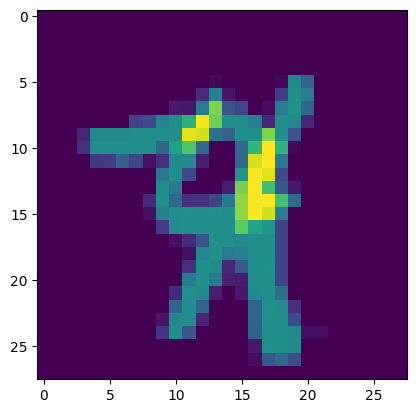

In [35]:
plt.imshow(train_dataset_autoencoder[54000][1].squeeze())

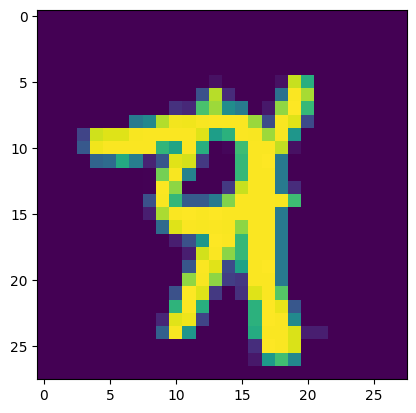

In [17]:
plt.imshow(train_dataset_autoencoder[54000][1].squeeze())

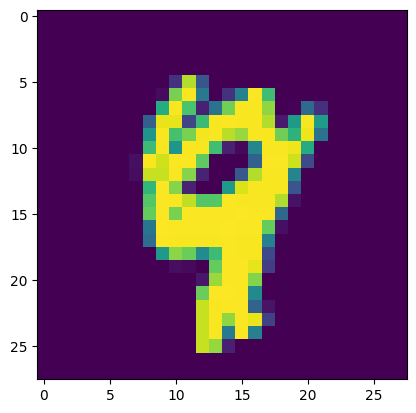

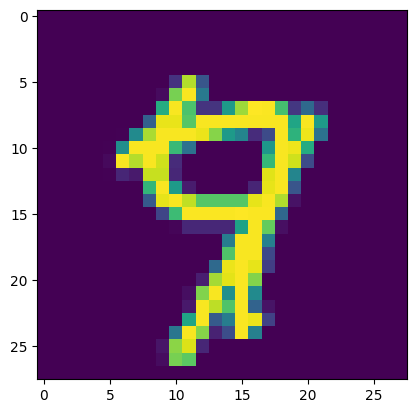

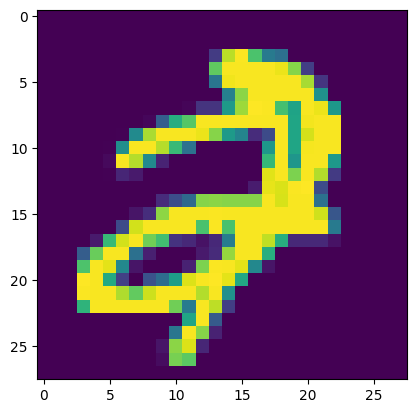

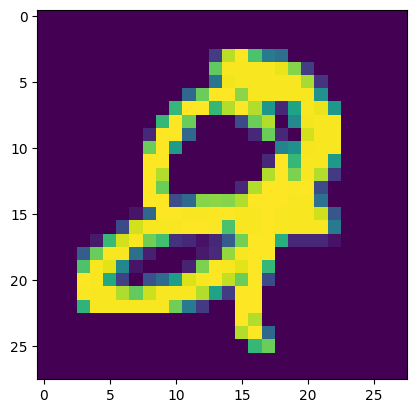

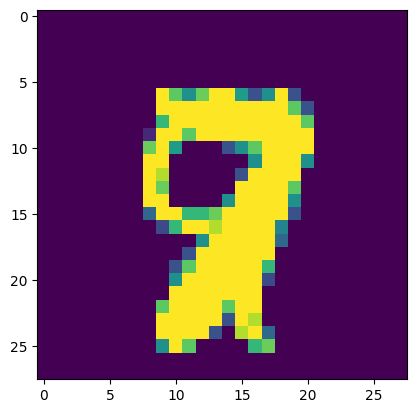

In [ ]:
# for idx in train_dataset_autoencoder.rand_samples_idx[:5]:
#   plt.imshow(train_dataset_autoencoder.mixed_subdataset[idx].squeeze(0))
#   plt.show()

In [14]:
def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)

    was_in_training = autoencoder.training
    autoencoder.eval()

    # Display some images..
    with torch.no_grad():
        samples = [sample[1] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)

    # Display loss/metrics plots.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            if name == "samples_losses":
              continue
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();

    autoencoder.train(was_in_training)

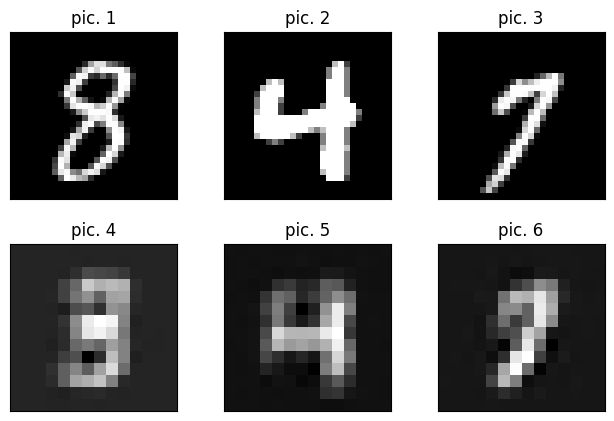

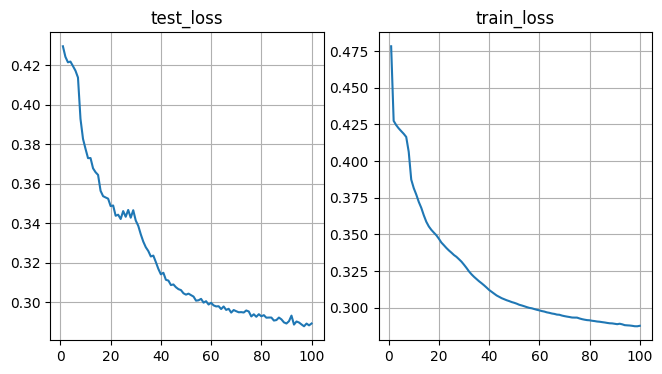

In [15]:
results = train_autoencoder(
    X_autoencoder,
    train_dataloader_autoencoder,
    test_dataloader_autoencoder,
    autoencoder_loss=autoencoder_loss,
    autoencoder_opt=autoencoder_opt,
    n_epochs=X_autoencoder_n_epochs,
    callback=autoencoder_callback,
    device=device,
)

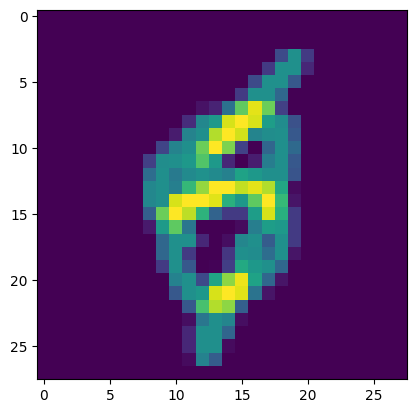

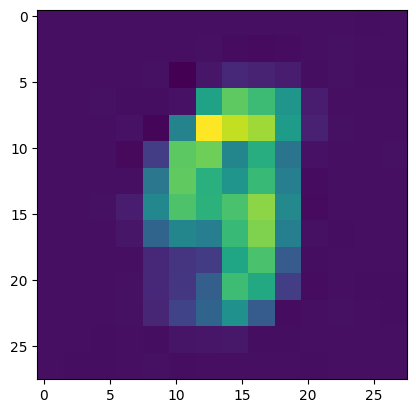

In [16]:
ri = 56001

with torch.no_grad():
  plt.imshow(train_dataset_autoencoder[ri][1].squeeze(0))
  plt.show()
  res_mix_img = X_autoencoder(train_dataset_autoencoder[ri][1].to(device).unsqueeze(0))
  plt.imshow(res_mix_img.squeeze(0).squeeze(0).cpu())
  plt.show()


In [17]:
samples_losses = results["samples_losses"]
# samples_losses

In [18]:
global_indexes = list(samples_losses.keys())
global_indexes[:5]

[56610, 30933, 4140, 43595, 9932]

In [ ]:
for epoch in range(0, X_autoencoder_n_epochs, 20):
  losses = []
  for g_idx in global_indexes:
    losses.append(samples_losses[g_idx][epoch])

  plt.hist(losses, bins=100)
  plt.title(f"Epoch {epoch + 1}")
  plt.show()

In [21]:
idx_2_sum_loss = {idx: 0 for idx in global_indexes}

start_from = 10
end = 100

for g_idx in global_indexes:
  for epoch in range(start_from, end):
    idx_2_sum_loss[g_idx] += samples_losses[g_idx][epoch]


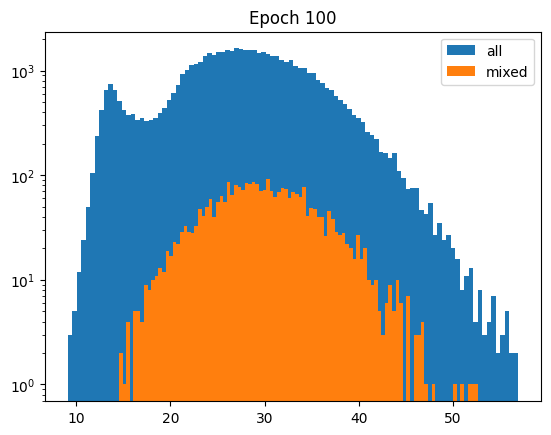

In [22]:
sum_losses = idx_2_sum_loss.values()
plt.hist(sum_losses, bins=100, label="all", log=True)


mixed_samples_losses = []
# for idx in train_dataset_autoencoder.rand_samples_idx:
for idx in range(54000, 57000):
  mixed_samples_losses.append(idx_2_sum_loss[idx])

plt.hist(mixed_samples_losses, bins=100, label="mixed", log=True)
plt.title(f"Epoch {epoch + 1}")
plt.legend()
plt.show()

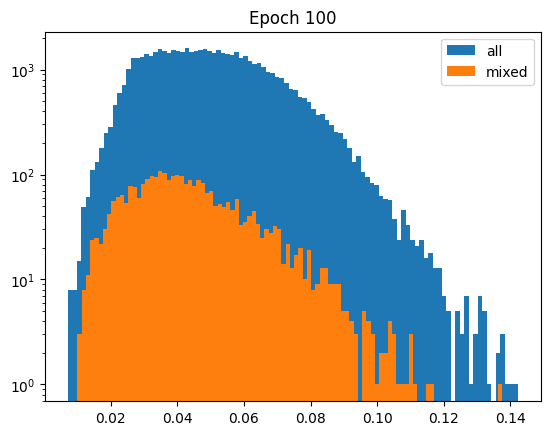

In [140]:
idx_2_std_loss = {idx: 0 for idx in global_indexes}

start_from = 5
end_to = 99

for g_idx in global_indexes:
  idx_2_std_loss[g_idx] = np.std(samples_losses[g_idx][start_from:end_to])

std_losses = idx_2_std_loss.values()
plt.hist(std_losses, bins=100, label="all", log=True)


mixed_samples_losses_std = []
# for idx in train_dataset_autoencoder.rand_samples_idx:
for idx in range(54000, 57000):
  mixed_samples_losses_std.append(idx_2_std_loss[idx])

plt.hist(mixed_samples_losses_std, bins=100, label="mixed", log=True)
plt.title(f"Epoch {epoch + 1}")
plt.legend()
plt.show()

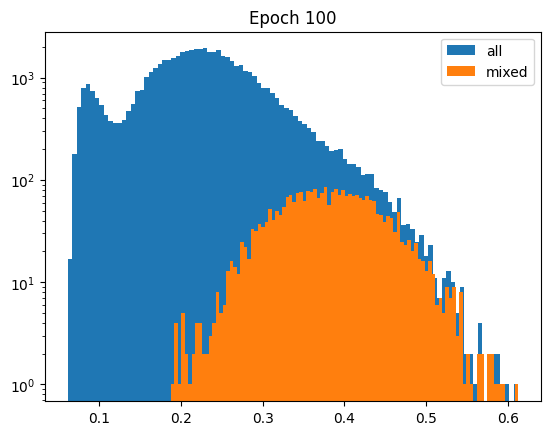

In [ ]:
idx_2_mean_loss = {idx: 0 for idx in global_indexes}


for g_idx in global_indexes:
  idx_2_mean_loss[g_idx] = np.mean(samples_losses[g_idx])

mean_losses = idx_2_mean_loss.values()
plt.hist(mean_losses, bins=100, label="all", log=True)


mixed_samples_losses_mean = []
# for idx in train_dataset_autoencoder.rand_samples_idx:
for idx in range(54000, 57000):
  mixed_samples_losses_mean.append(idx_2_mean_loss[idx])

plt.hist(mixed_samples_losses_mean, bins=100, label="mixed", log=True)
plt.title(f"Epoch {epoch + 1}")
plt.legend()
plt.show()

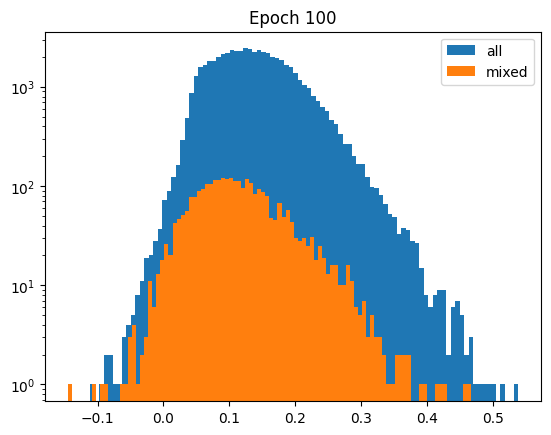

In [54]:
idx_2_sum_loss_2 = {idx: 0 for idx in global_indexes}

start_from = 10
end = start_from + 1

for g_idx in global_indexes:
  for epoch in range(start_from, end):
    idx_2_sum_loss_2[g_idx] += samples_losses[g_idx][epoch]


start_from = 99
end = start_from + 1

for g_idx in global_indexes:
  for epoch in range(start_from, end):
    idx_2_sum_loss_2[g_idx] -= samples_losses[g_idx][epoch]


sum_losses_2 = idx_2_sum_loss_2.values()
plt.hist(sum_losses_2, bins=100, label="all", log=True)


mixed_samples_losses_2 = []
for idx in range(54000, 57000):
  mixed_samples_losses_2.append(idx_2_sum_loss_2[idx])

plt.hist(mixed_samples_losses_2, bins=100, label="mixed", log=True)
plt.title(f"Epoch {epoch + 1}")
plt.legend()
plt.show()

<ipython-input-135-ddf33a1d7b18>:3: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


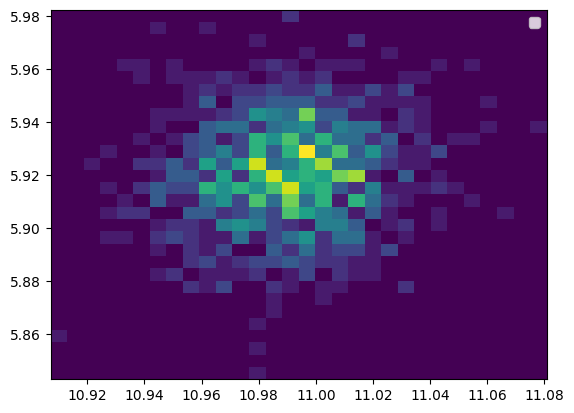

In [ ]:
plt.hist2d(sum_losses, sum_losses_2, bins=30, label="All", alpha=0.1)
plt.hist2d(mixed_samples_losses, mixed_samples_losses_2, bins=30, label="mixed")
plt.legend()
plt.show()

In [ ]:
import numpy as np

In [103]:
q = np.quantile(np.array(list(sum_losses)), q=0.94738)
print(q)
sum(np.array(list(sum_losses)) > q)

34.47317278104424


3000

342

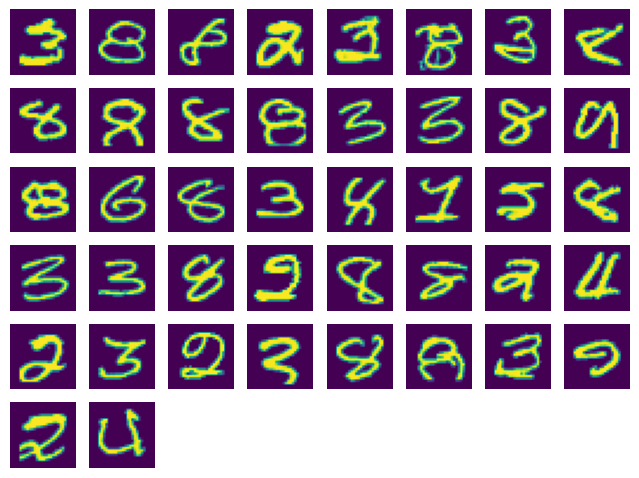

In [71]:
counter = 1

plt.figure(figsize=(8, 8))
for idx, sl in idx_2_sum_loss.items():
  if sl > q and idx < 54000:
    plt.subplot(8, 8, counter)
    plt.imshow(train_dataset_autoencoder[idx][1].squeeze(0))
    # plt.title(f"global index - {idx}")
    plt.axis('off')
    counter += 1

plt.show()

In [74]:
q_1 = np.quantile(np.array(list(sum_losses)), q=0.009)
print(q_1)
sum(np.array(list(sum_losses)) < q_1)

3.3140703905038538


513

ValueError: num must be an integer with 1 <= num <= 64, not 65

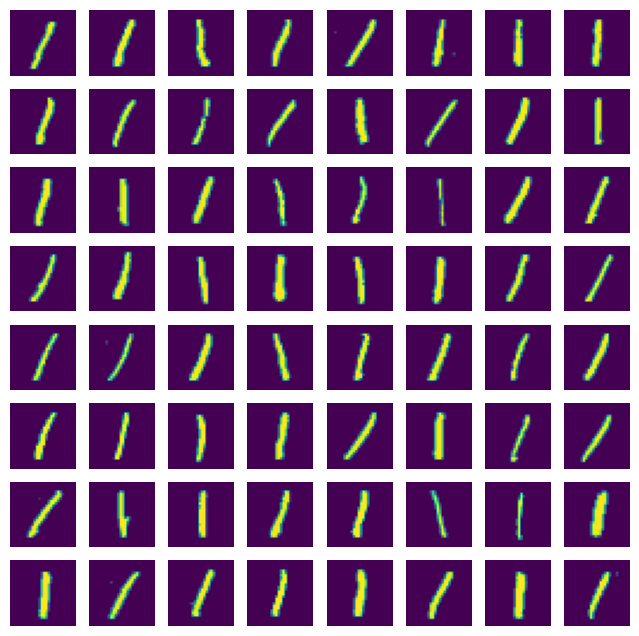

In [78]:
counter = 1

plt.figure(figsize=(8, 8))

for idx, sl in idx_2_sum_loss.items():
  if 4 < sl < 4.2:
    plt.subplot(8, 8, counter)
    plt.imshow(train_dataset_autoencoder[idx][1].squeeze(0))
    # plt.title(f"global index - {idx}")
    plt.axis('off')
    counter += 1

plt.show()

In [21]:
import pandas as pd

df = pd.DataFrame(samples_losses)
df

,24843,53435,13964,50719,33492,13181,38933,23356,49625,10862,...,24725,30341,33510,38754,24618,11140,21274,25666,21217,35637
0,0.468910,0.314389,0.679507,0.390326,0.338268,0.471616,0.304559,0.480588,0.525710,0.189263,...,0.369353,0.431916,0.217001,0.300074,0.385873,0.393947,0.389105,0.224619,0.478792,0.527674
1,0.468573,0.309739,0.674145,0.390368,0.337626,0.468843,0.303328,0.471981,0.522751,0.187346,...,0.365777,0.429119,0.213041,0.297230,0.382477,0.388163,0.385842,0.219864,0.472753,0.522968
2,0.549965,0.346954,0.618107,0.452697,0.398946,0.439463,0.291529,0.413766,0.518786,0.239629,...,0.351449,0.466548,0.205113,0.295832,0.402226,0.407447,0.412098,0.206828,0.446676,0.552068
3,0.544273,0.338506,0.615887,0.464785,0.410209,0.445344,0.292769,0.436947,0.510015,0.243966,...,0.354137,0.466096,0.225169,0.303904,0.395551,0.396667,0.413574,0.233458,0.468918,0.552452
4,0.474659,0.311474,0.490262,0.390027,0.337008,0.433196,0.283102,0.344372,0.499811,0.182395,...,0.340648,0.424679,0.196910,0.279139,0.376688,0.384738,0.392043,0.212800,0.465535,0.526672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.214168,0.172422,0.164487,0.142619,0.104871,0.198829,0.155599,0.103788,0.162855,0.058175,...,0.250703,0.173732,0.046587,0.121794,0.199686,0.133811,0.180154,0.060726,0.200265,0.132902
96,0.247171,0.161712,0.169760,0.153966,0.105468,0.208779,0.123181,0.112302,0.165125,0.067914,...,0.249399,0.186592,0.048216,0.129949,0.183717,0.140722,0.178591,0.050878,0.191581,0.157529
97,0.214878,0.161206,0.181695,0.140384,0.099976,0.204543,0.134146,0.103097,0.162409,0.060642,...,0.239440,0.214984,0.049033,0.128325,0.199037,0.158259,0.175566,0.062737,0.191659,0.134423
98,0.277550,0.173270,0.169018,0.148103,0.094409,0.209739,0.131242,0.133302,0.169357,0.062990,...,0.248454,0.183486,0.052145,0.141241,0.207904,0.154577,0.174875,0.064059,0.184042,0.132304


In [ ]:
import pandas as pd

df = pd.DataFrame(samples_losses)
df

,24843,53435,13964,50719,33492,13181,38933,23356,49625,10862,...,24725,30341,33510,38754,24618,11140,21274,25666,21217,35637
0,0.438372,0.438372,0.438372,0.438372,0.438372,0.438372,0.438372,0.438372,0.438372,0.438372,...,0.448811,0.448811,0.448811,0.448811,0.448811,0.448811,0.448811,0.448811,0.448811,0.448811
1,0.419010,0.425276,0.429298,0.433580,0.438088,0.434283,0.422605,0.425909,0.427426,0.422605,...,0.432638,0.436503,0.422556,0.438466,0.430264,0.430264,0.416996,0.433344,0.429131,0.428492
2,0.434637,0.423370,0.413920,0.425016,0.430800,0.415374,0.428132,0.432814,0.418890,0.419971,...,0.421001,0.416264,0.415435,0.435513,0.420546,0.416159,0.420808,0.417925,0.415905,0.421891
3,0.434141,0.423687,0.429054,0.428122,0.428843,0.431092,0.428863,0.429961,0.437023,0.436428,...,0.423575,0.429516,0.433376,0.425013,0.423737,0.438909,0.429008,0.424591,0.431572,0.428863
4,0.421118,0.421118,0.410524,0.409880,0.417274,0.417284,0.417156,0.415624,0.418873,0.418000,...,0.424615,0.422155,0.410459,0.409880,0.405263,0.408639,0.410949,0.414919,0.409415,0.418768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.193498,0.193221,0.195106,0.197896,0.194234,0.193111,0.192520,0.191297,0.203503,0.193375,...,0.196220,0.188757,0.193023,0.192891,0.193498,0.194155,0.188073,0.193614,0.189590,0.195106
96,0.196743,0.202671,0.196938,0.201438,0.199791,0.198776,0.197812,0.199665,0.203861,0.197096,...,0.201136,0.198378,0.192149,0.197842,0.201203,0.201136,0.197390,0.197547,0.196743,0.192149
97,0.198492,0.194016,0.193859,0.190957,0.198057,0.200041,0.193829,0.197740,0.194588,0.193068,...,0.192124,0.195055,0.192417,0.187293,0.193829,0.193481,0.193534,0.190022,0.195243,0.191177
98,0.193159,0.198356,0.198596,0.191237,0.197007,0.193809,0.187866,0.191387,0.190487,0.197155,...,0.192835,0.189055,0.191815,0.190431,0.193379,0.190388,0.190431,0.192370,0.190173,0.190224


In [22]:
df.to_csv("samples_losses_57k_100epochs_mix_like_maximum.csv", index=False)

In [23]:
from google.colab import files
files.download("samples_losses_57k_100epochs_mix_like_maximum.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Metrics

In [107]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [81]:
y_true = np.hstack((np.zeros(54000), np.ones(3000)))
y_true

array([0., 0., 0., ..., 1., 1., 1.])

In [105]:
q = np.quantile(np.array(list(sum_losses)), q=0.94738)
print(q)
sum(np.array(list(sum_losses)) > q)

34.47317278104424


3000

In [106]:
preds = np.zeros(57000)
for idx, sl in idx_2_sum_loss.items():
  if sl > q:
    preds[idx] = 1

preds

array([0., 0., 0., ..., 1., 0., 1.])

In [108]:
print(f"{f1_score(y_true, preds)=}")
print(f"{precision_score(y_true, preds)=}")
print(f"{recall_score(y_true, preds)=}")

f1_score(y_true, preds)=0.5023333333333333
precision_score(y_true, preds)=0.5023333333333333
recall_score(y_true, preds)=0.5023333333333333


In [118]:
preds_sl = [idx_2_sum_loss[idx] for idx in global_indexes if preds[idx] == 1]
len(preds_sl)

3000

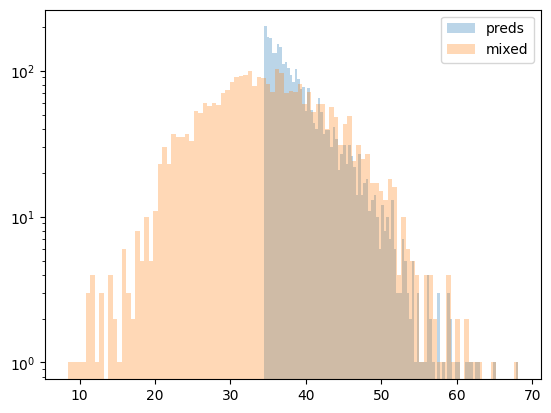

In [127]:
plt.hist(preds_sl, bins=100, label="preds", log=True, alpha=0.3)
plt.hist(mixed_samples_losses, bins=100, label="mixed", log=True, alpha=0.3)
plt.legend()
plt.show()